This is an example notebook to test stuff

Below is code by Igor:

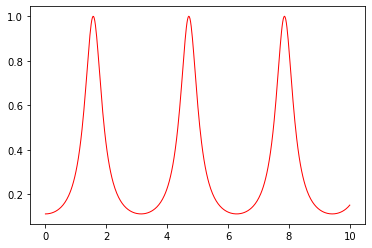

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath as cm

def transmitance(mirror,pos,k):
    lengths=[]
    for i in range(len(pos)-1):
        lengths.append(pos[i+1]-pos[i])
    op=[mirror]
    for x in lengths:
        op.append([[cm.exp(x*k*1j),0],[0,cm.exp(-x*k*1j)]])
        op.append(mirror)
    M=np.linalg.multi_dot(op)
    T=1./(abs(np.dot(np.linalg.inv(M),[1,0])[0])**2)
    return T

def plot(mirror,pos,kmin,kmax):
    kspace=np.linspace(kmin,kmax,500)
    Tspace=[]
    for k in kspace:
        Tspace.append(transmitance(mirror,pos,k))
    plt.plot(kspace,Tspace,color='r',linestyle='-',linewidth=1)
    plt.show()

plot([[np.sqrt(2),1],[1,np.sqrt(2)]],[0,1],0,10)